In [2]:
import DDPG #from the article 
import torch
import gymnasium as gym
import os
import numpy as np
from utils import ReplayBuffer #from the TD3 article
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env_name="HalfCheetah-v4"

In [2]:
def evaluate_policy(policy, env, replay_buffer, discount=0.99, eval_episodes=10):
    sampled_states = replay_buffer.sample(eval_episodes)[0]
    
    returns = []
    for state in sampled_states:
        state=state.cpu()
        done = False
        total_reward = 0
        discount_factor = 1
        while not done:
            action = policy.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += discount_factor * reward
            discount_factor *= discount
            state = next_state
        returns.append(total_reward)
    
    true_value_mean = np.mean(np.array(returns))
    
    return true_value_mean


In [3]:
def compute_average_value(policy,env,num_states):
    whereto=policy.critic.l1.weight.device
    sampled_states=[env.observation_space.sample() for i in range(num_states)]
    sampled_states_torch=[torch.FloatTensor(s).unsqueeze(0).to(whereto) for s in sampled_states]
    chosen_actions=[policy.select_action(s)for s in sampled_states]
    chosen_actions_torch=[torch.FloatTensor(a).unsqueeze(0).to(whereto) for a in chosen_actions]
    hold=np.array([policy.critic(s,a).item() for s,a in zip(sampled_states_torch,chosen_actions_torch)])
    avg_value_estimate = np.mean(hold)
    std=np.std(hold)
    return avg_value_estimate,std

In [4]:
env = gym.make("HalfCheetah-v4")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

policy = DDPG.DDPG(state_dim, action_dim, max_action)
replay_buffer = ReplayBuffer(state_dim, action_dim)

avg_value_mean=[]
avg_value_std=[]
true_values=[]

state, _ = env.reset()
for t in range(int(1e4)):
    if t%50==0:
        print(t)
    action = policy.select_action(state)
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    replay_buffer.add(state, action, next_state, reward, done)
    state = next_state if not done else env.reset()[0]
    if len(replay_buffer) > 1000:
        policy.train(replay_buffer)
        mean,std=compute_average_value(policy,env,num_states=1000)
        avg_value_mean.append(mean)
        avg_value_std.append(std)
    if (t + 1) % 1000 == 0:
        true_value = evaluate_policy(policy, env, replay_buffer)
        true_values.append([t,true_value])
        print(f"Step {t+1}, True Value Mean: {true_value:.3f}")
        
os.makedirs("DDPG_res", exist_ok=True)
eval_data = {
        'avg_mean': np.array(avg_value_mean),
        'std': np.array(avg_value_std),
        'true_val':np.array(true_values)
    }
np.save("DDPG_res/evaluation.npy", eval_data)
policy.save("DDPG_res/ddpg_model")
print("Training complete. Model and results saved.")

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
Step 1000, True Value Mean: -0.014
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
Step 2000, True Value Mean: -0.006
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
Step 3000, True Value Mean: -0.007
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
Step 4000, True Value Mean: -0.007
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
Step 5000, True Value Mean: -0.007
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
Step 6000, True Value Mean: -0.007
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
Step 7000, True Value Mean: -0.007
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
775

In [4]:
data=np.load('DDPG_res/evaluation.npy',allow_pickle=True).item()

mean=data['avg_mean']
std=data['std']
true_val=data['true_val']

In [13]:
print(true_val[0])

[ 9.9900000e+02 -1.4455948e-02]


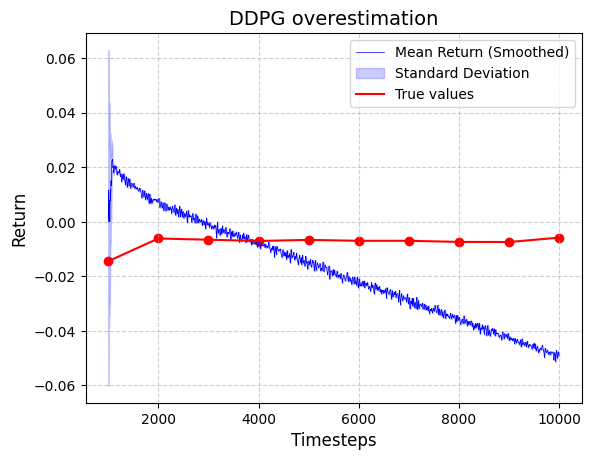

In [5]:
from scipy.ndimage import uniform_filter1d
timesteps=np.arange(1e3,1e4,1)
smoothed_mean = uniform_filter1d(mean, size=10)
plt.plot(timesteps, smoothed_mean, color='blue', linewidth=0.5, label='Mean Return (Smoothed)')
plt.fill_between(
    timesteps, 
    smoothed_mean - std, 
    smoothed_mean + std, 
    alpha=0.2, 
    color='blue',
    label='Standard Deviation'
)
plt.plot(true_val[:,0],true_val[:,1],color='red',label='True values')
plt.scatter(true_val[:,0],true_val[:,1],color='red')
    
# Additional plot styling
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Timesteps', fontsize=12)
plt.ylabel('Return', fontsize=12)
plt.title('DDPG overestimation', fontsize=14)
plt.savefig('DDPG_res/overestimation_plot.png')
plt.legend(loc='best')